In [6]:
# Imports
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, classification_report
)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [ ]:
df = pd.read_csv("Synth_transactions.csv")
TARGET_COL = "IsFraud"
drop_cols = ["TransactionID", "UserID", "IsFlaggedFraud"]

X = df.drop(columns=drop_cols + [TARGET_COL], errors="ignore").copy()
y = df[TARGET_COL].astype(int)

if "TransactionTime" in X.columns:
    X["TransactionHour"] = pd.to_datetime(X["TransactionTime"], errors="coerce").dt.hour
    X = X.drop(columns=["TransactionTime"])

print("X shape:", X.shape, "| y distribution:\n", y.value_counts(normalize=True))



X shape: (50000, 7) | y distribution:
 IsFraud
0    0.97086
1    0.02914
Name: proportion, dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

transformers = []
if num_cols:
    transformers.append(("num", StandardScaler(), num_cols))
if cat_cols:
    transformers.append(("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols))

preprocessor = ColumnTransformer(transformers, remainder="drop")


In [ ]:
def evaluate(model, X_te, y_te, name: str):
    y_pred = model.predict(X_te)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_te)[:, 1]
    else:
        y_proba = y_pred.astype(float)
    metrics = {
        "model": name,
        "accuracy": accuracy_score(y_te, y_pred),
        "precision": precision_score(y_te, y_pred, zero_division=0),
        "recall": recall_score(y_te, y_pred, zero_division=0),
        "f1": f1_score(y_te, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_te, y_proba),
        "avg_precision": average_precision_score(y_te, y_proba)
    }
    return metrics, y_pred


In [ ]:
svm_pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf", SVC(kernel="rbf", C=10, gamma="scale", probability=True, class_weight="balanced", random_state=RANDOM_STATE))
])

rf_pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=300, class_weight="balanced_subsample", random_state=RANDOM_STATE, n_jobs=-1))
])

cb_pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf", CatBoostClassifier(
        iterations=500,
        depth=6,
        learning_rate=0.1,
        auto_class_weights="Balanced",
        verbose=0,
        random_seed=RANDOM_STATE
    ))
])


In [ ]:
svm_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)
cb_pipeline.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
stacking_model = StackingClassifier(
    estimators=[("svm", svm_pipeline), ("rf", rf_pipeline), ("cb", cb_pipeline)],
    final_estimator=LogisticRegression(class_weight="balanced", max_iter=500, random_state=RANDOM_STATE),
    stack_method="predict_proba",
    n_jobs=-1
)
stacking_model.fit(X_train, y_train)


,estimators,"[('svm', ...), ('rf', ...), ...]"
,final_estimator,LogisticRegre...ndom_state=42)
,cv,None
,stack_method,'predict_proba'
,n_jobs,-1
,passthrough,False
,verbose,0
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None


In [ ]:
svm_metrics, svm_pred = evaluate(svm_pipeline, X_test, y_test, "SVM")
rf_metrics, rf_pred = evaluate(rf_pipeline, X_test, y_test, "RandomForest")
cb_metrics, cb_pred = evaluate(cb_pipeline, X_test, y_test, "CatBoost")
stack_metrics, stack_pred = evaluate(stacking_model, X_test, y_test, "Hybrid_Stacking")

results = pd.DataFrame([svm_metrics, rf_metrics, cb_metrics, stack_metrics]).set_index("model")
results = results.sort_values("avg_precision", ascending=False)
display(results.style.format("{:.4f}"))


,accuracy,precision,recall,f1,roc_auc,avg_precision
model,,,,,,
SVM,0.9364,0.0195,0.0241,0.0215,0.5248,0.0323
Hybrid_Stacking,0.5873,0.0299,0.4192,0.0558,0.4986,0.0282
CatBoost,0.8641,0.0232,0.0893,0.0369,0.4824,0.0282
RandomForest,0.9708,0.0000,0.0000,0.0000,0.4748,0.0271


In [ ]:
def show_report(name, y_true, y_pred):
    print(f"\n{name}")
    print(classification_report(y_true, y_pred, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

show_report("SVM", y_test, svm_pred)
show_report("RandomForest", y_test, rf_pred)
show_report("CatBoost", y_test, cb_pred)
show_report("Hybrid_Stacking", y_test, stack_pred)


SVM
              precision    recall  f1-score   support

           0     0.9705    0.9637    0.9671      9709
           1     0.0195    0.0241    0.0215       291

    accuracy                         0.9364     10000
   macro avg     0.4950    0.4939    0.4943     10000
weighted avg     0.9429    0.9364    0.9396     10000

Confusion Matrix:
 [[9357  352]
 [ 284    7]]

RandomForest
              precision    recall  f1-score   support

           0     0.9709    0.9999    0.9852      9709
           1     0.0000    0.0000    0.0000       291

    accuracy                         0.9708     10000
   macro avg     0.4854    0.4999    0.4926     10000
weighted avg     0.9426    0.9708    0.9565     10000

Confusion Matrix:
 [[9708    1]
 [ 291    0]]

CatBoost
              precision    recall  f1-score   support

           0     0.9702    0.8873    0.9269      9709
           1     0.0232    0.0893    0.0369       291

    accuracy                         0.8641     10000
   macr

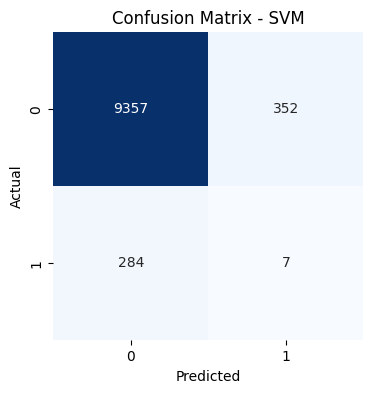

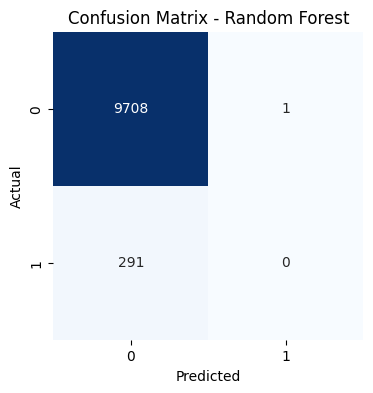

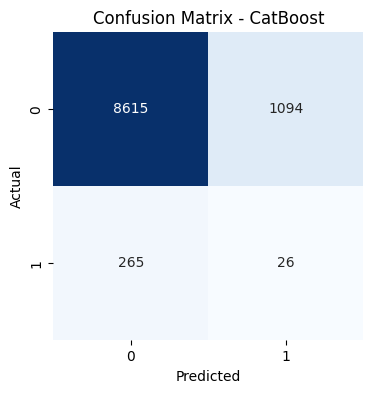

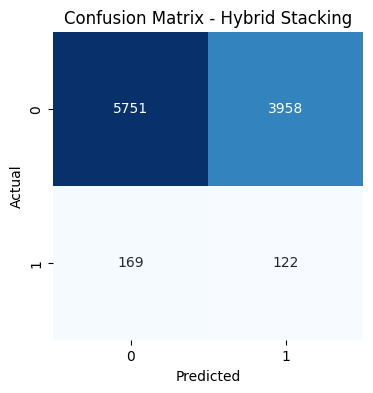

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion(y_test, svm_pred, "SVM")
plot_confusion(y_test, rf_pred, "Random Forest")
plot_confusion(y_test, cb_pred, "CatBoost")
plot_confusion(y_test, stack_pred, "Hybrid Stacking")


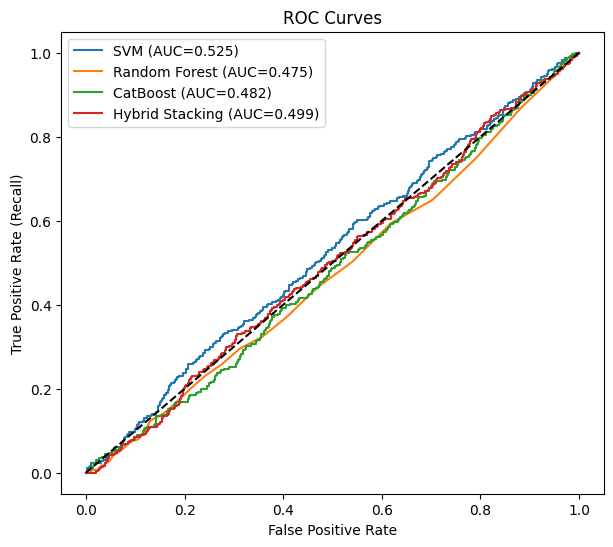

In [ ]:
plt.figure(figsize=(7,6))

for model, preds, name in [
    (svm_pipeline, svm_pred, "SVM"),
    (rf_pipeline, rf_pred, "Random Forest"),
    (cb_pipeline, cb_pred, "CatBoost"),
    (stacking_model, stack_pred, "Hybrid Stacking"),
]:
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        y_proba = preds
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves")
plt.legend()
plt.show()


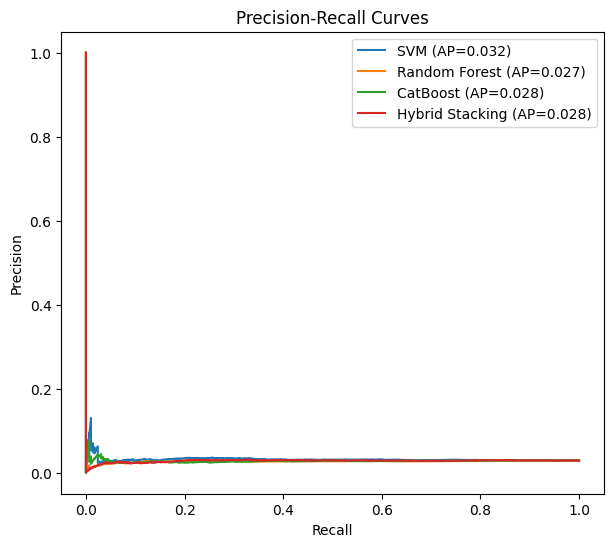

In [ ]:
plt.figure(figsize=(7,6))

for model, preds, name in [
    (svm_pipeline, svm_pred, "SVM"),
    (rf_pipeline, rf_pred, "Random Forest"),
    (cb_pipeline, cb_pred, "CatBoost"),
    (stacking_model, stack_pred, "Hybrid Stacking"),
]:
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        y_proba = preds
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(rec, prec, label=f"{name} (AP={auc(rec,prec):.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()


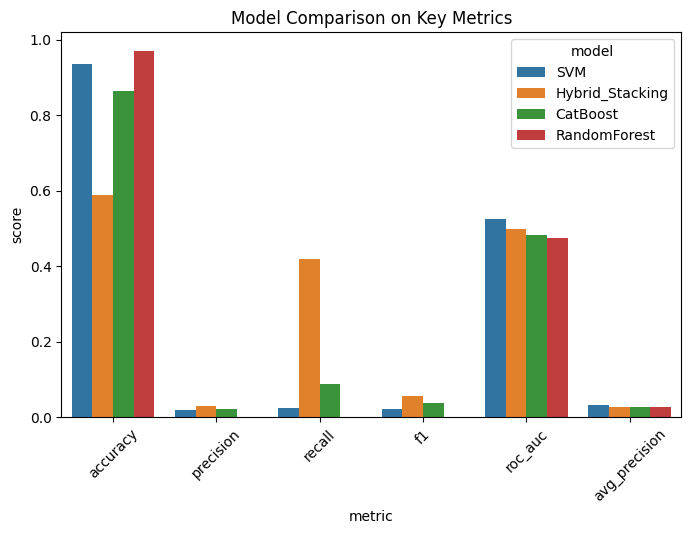

In [ ]:
plt.figure(figsize=(8,5))
results_plot = results.reset_index().melt(id_vars="model", var_name="metric", value_name="score")
sns.barplot(data=results_plot, x="metric", y="score", hue="model")
plt.title("Model Comparison on Key Metrics")
plt.xticks(rotation=45)
plt.show()
